In [1]:
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

In [2]:
def sv_base(mat, b):
    res = mat * b
    
def sv_cp(mat, b):
    res = mat * b
    
@jit(nopython=True, parallel=True)
def sv_nb(A, iA, jA, b, res):
    for row in prange(len(iA)-1):
        res[row] = 0
        for i in prange(iA[row], iA[row+1]):
            res[row] += A[i]*b[jA[i]] 

In [3]:
N = [int(8*(2**0.5)**i) for i in range(28)]
methods = ["sv_base", "sv_cp", "sv_nb"]
K = len(methods)
funcs = [sv_base, sv_cp, sv_nb]
masks = [1, 1, 1]
groups = [0, 0, 0]
T = [[] for i in range(K)]
deg = 40
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n*deg))
    data = np.random.rand(n*deg)
    b = np.random.rand(n)
    cb = cp.array(b)
    mat = coo_matrix((data,(row, col)), shape=(n,n)).tocsr()
    cmat = cp_coo_matrix((cp.array(data), (cp.array(row), cp.array(col))), shape=(n,n)).tocsr()
    
    res = np.zeros(n)
    args = [(mat, b), (cmat, cb), (mat.data, mat.indptr, mat.indices, b, res)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 3 -o funcs[i](*args[i])
        T[i].append(t.average*1000)

Start with size: 8
Start with size: 11
Start with size: 16
Start with size: 22
Start with size: 32
Start with size: 45
Start with size: 64
Start with size: 90
Start with size: 128
Start with size: 181
Start with size: 256
Start with size: 362
Start with size: 512
Start with size: 724
Start with size: 1024
Start with size: 1448
Start with size: 2048
Start with size: 2896
Start with size: 4096
Start with size: 5792
Start with size: 8192
Start with size: 11585
Start with size: 16384
Start with size: 23170
Start with size: 32768
Start with size: 46340
Start with size: 65536
Start with size: 92681


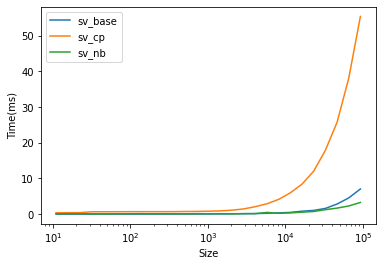

In [4]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [5]:
print(T)

[[0.019735666531535873, 0.00777033331663309, 0.00857466648085392, 0.007640999986809524, 0.008325666537227031, 0.010169333412098544, 0.009364666614904612, 0.011049000022467226, 0.011095666650362546, 0.012852666562442513, 0.015783333310537273, 0.01960066659497291, 0.025205666588590248, 0.031876333347706044, 0.04678533332480583, 0.05538166669794009, 0.08866833316763707, 0.11131199986872768, 0.1622253333456077, 0.23543833337195488, 0.3533426667369592, 0.4860636668126972, 0.8295486668430385, 1.0445433332885539, 1.6070136665196817, 2.8358900000663803, 4.550713999985116, 7.058538666721385], [0.5205473332049829, 0.40117533323306515, 0.4145966668147594, 0.42871966661550687, 0.6667839998044656, 0.6720429999707752, 0.6770733333117581, 0.6938623332644056, 0.6928693334581718, 0.6985476669190879, 0.6967046665522503, 0.7023063333993681, 0.7419606668008782, 0.7614643333605878, 0.8304129999790651, 0.9172466666313994, 1.1140709999987546, 1.4673426665770724, 2.0979836666204696, 2.911769000093045, 4.14683